In [27]:
import cv2
import numpy as np
import glob
import pytesseract
from pytesseract import Output
import re
from skimage import filters
import imutils
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11,7)

### Redimensionamento das imagens

In [28]:
#funcao para cortar parte preta das imagens capturadas pela camera chinesa, pois atrapalham a segmentação
def cropImg(img):
    crop = img[1000:1800, 1200:2200]
    return crop

In [48]:
def sift_align(img1, img2):
    
    # Converte imagens para cinza
    img1Gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2Gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detecta recursos SIFT
    sift = cv2.SIFT_create(5000)
    keypoints1, descriptors1 = sift.detectAndCompute(img1Gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2Gray, None)

    # Match features (Recursos de combinações)
    matcher = cv2.DescriptorMatcher_create(cv2.NORM_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Organiza os matches por pontuação
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remova combinações não tão boas
    numGoodMatches = int(len(matches) * 2)
    matches = matches[:numGoodMatches]

    # salva os melhores matches
    imgMatches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imgMatches)

    # Extrai a localizão do bons matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Encontra homografia
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Usa homografia
    height, width, channels = img2.shape
    
    img1Reg = cv2.warpPerspective(img1, h, (width, height))

    return img1Reg, h

### Segmentação

In [30]:
def inverte(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray,155,255,cv2.THRESH_BINARY)
    #ret,thresh2 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
    return thresh1

In [31]:
def bilateral(img):
    bil = cv2.bilateralFilter(img, 5, 35, 35) #3, 21, 21 #5, 35, 35 #7, 49, 49 #9, 63, 63 #11, 77, 77
    return bil

In [32]:
def sharpenFunction(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) #matriz de convolução que aplica nitidez
    return cv2.filter2D(image, -1, kernel)

In [33]:
def filterFunction(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)#
    (T,Thresh1) = cv2.threshold(image, 200, 255, cv2.THRESH_TRUNC)
    Thresh2 = cv2.adaptiveThreshold(Thresh1, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 231,50)#
    return Thresh2

In [34]:
def cleanImage(image, stage = 0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    # aplicando as operações topHat/blackHat
    topHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel) #revela as áreas claras com fundo escuro
    blackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel) #revela as áreas escuras com um fundo claro
    # fazendo adição e subtração entre as operações morfológicas
    add = cv2.add(gray, topHat)
    subtract = cv2.subtract(add, blackHat)
    if (stage == 1):
        return subtract
    T = filters.threshold_local(subtract, 21, offset=45, method="gaussian", mode="mirror")
    thresh = (subtract > T).astype("uint8") * 255
    if (stage == 2):
        return thresh
    # inverte a imagem 
    thresh = cv2.bitwise_not(thresh)
    return thresh

### Delimitação de ROIs e extração de dados

In [35]:
def data_keys(img):
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    return d

In [36]:
def drawboxes(img, d):
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        #if int(d['conf'][i]) > 40:
        if int(d['left'][i]) > 60 and int(d['top'][i]) > 95:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img

In [37]:
#limpa caracteres não ASCII
def cleanup_text(text):
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()

In [38]:
def extraiNome(img):
    crop = img[110:180, 120:850]
    text = pytesseract.image_to_string(crop, lang='por')
    name = cleanup_text(text)
    name = re.findall('[A-Z]+', name)
    nomecomp = ""
    
    for n in name:
        nomecomp += f" {n}"
    
    res = re.sub("NOME[ ]+", "", nomecomp)
    
    print(nomecomp)
    
    return crop

In [39]:
def get_cpf_roi(img):
    
    imgcrop = img[240:290, 415:670]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    cpf = ""
    
    cpf = re.findall('\d{3}\.\d{3}\.\d{3}\-\d{2}', text)
     
    print("CPF:", cpf)
    print(text)
    
    return imgcrop

In [40]:
def get_datanasc_roi(img):
    
    imgcrop = img[240:300, 670:850]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    print(text)
    data = re.findall('^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$', text)
    
    return imgcrop

In [41]:
def get_nreg_roi(img):
    
    imgcrop = img[510: , 110:420]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    num = re.findall('[0-9]+', text)
    numreg = ""
    
    for n in num:
        numreg += f" {n}"
        
    print(numreg)
    
    return imgcrop

In [42]:
def get_dataval_roi(img):
    
    imgcrop = img[290:290+50, 210:210+125]
    text = pytesseract.image_to_string(imgcrop, lang='por')
    data = re.findall('\d+/\d+/\d+', text)
    print(data)
    
    return imgcrop

### Chamada das funções

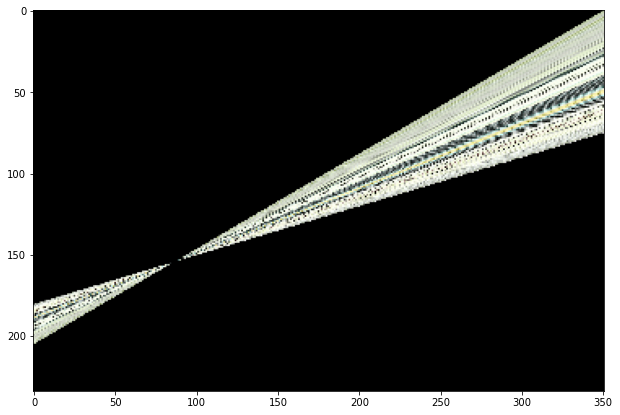

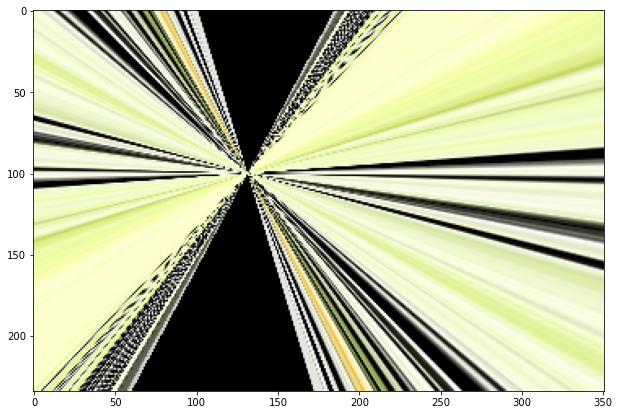

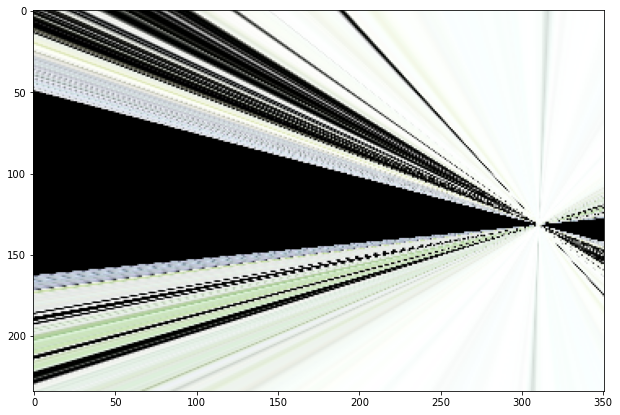

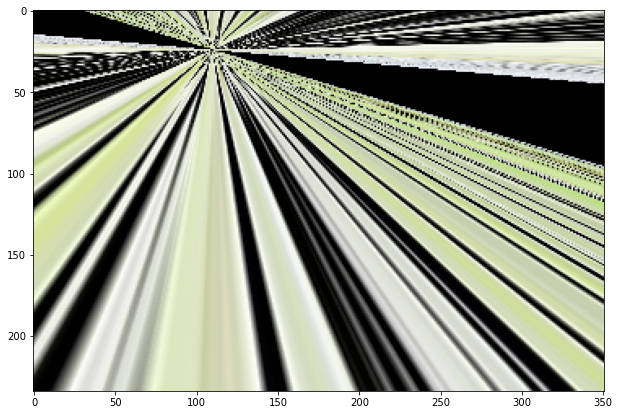

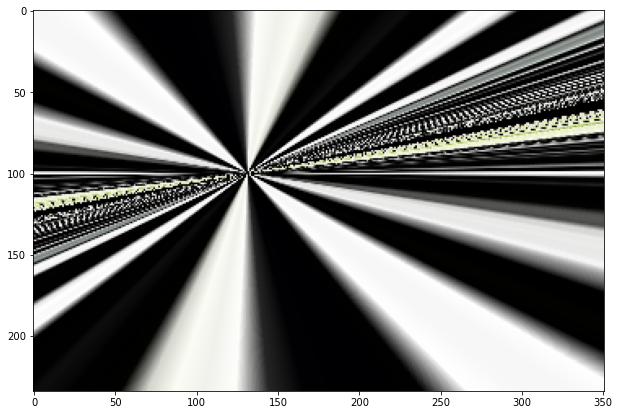

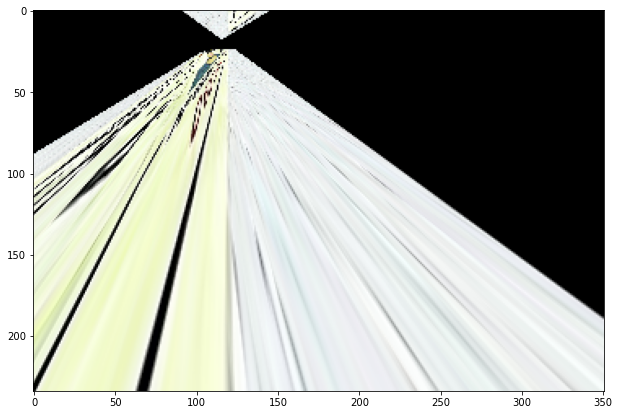

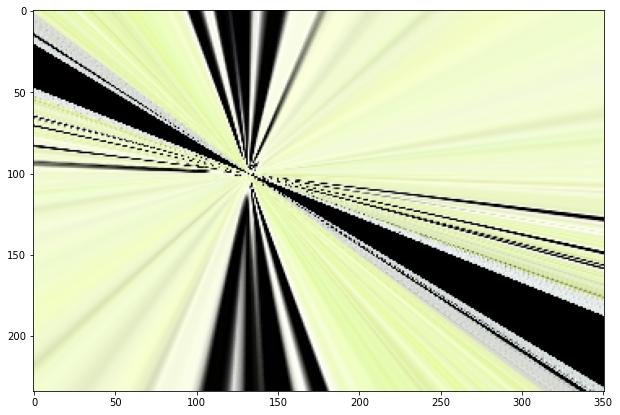

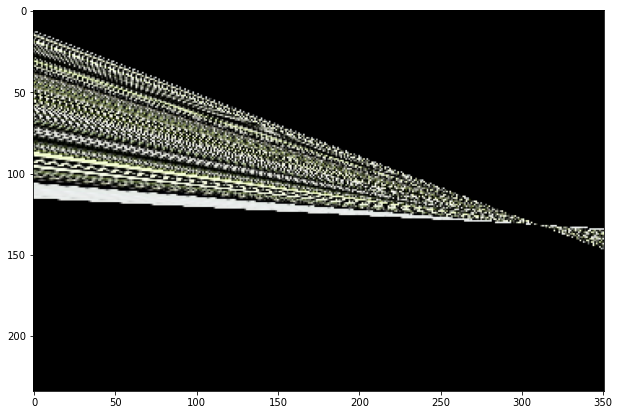

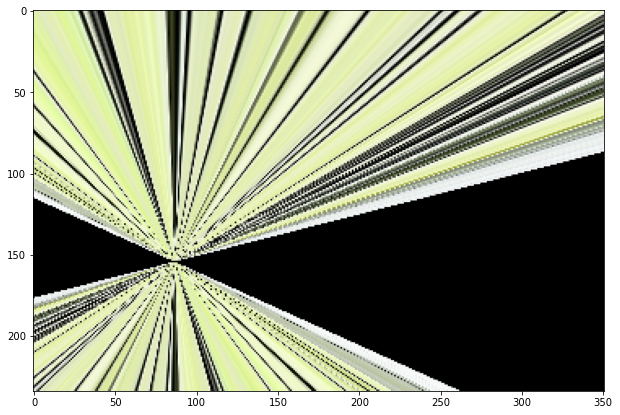

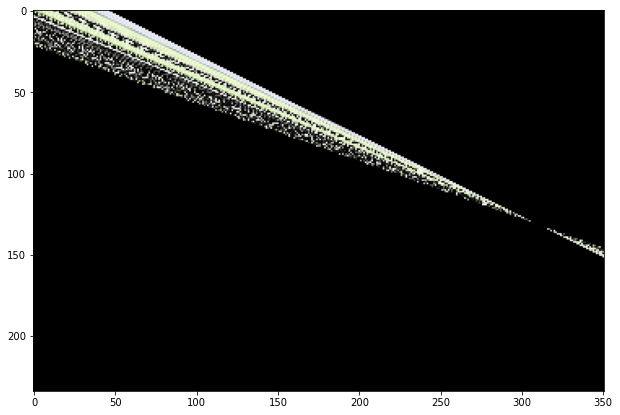

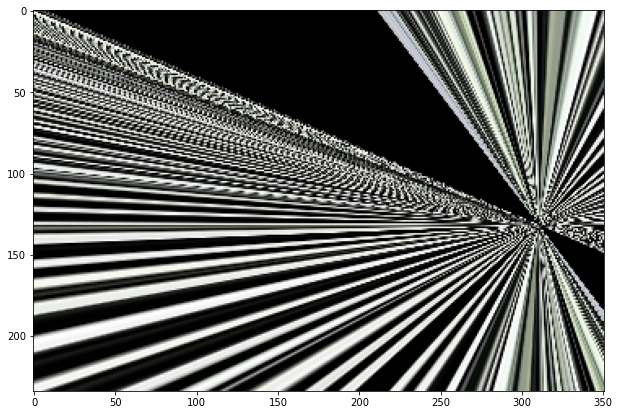

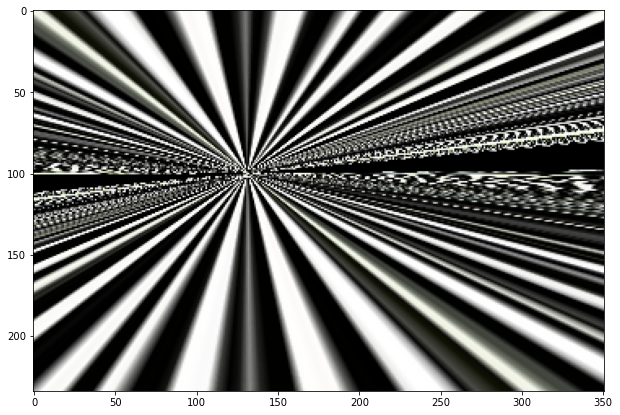

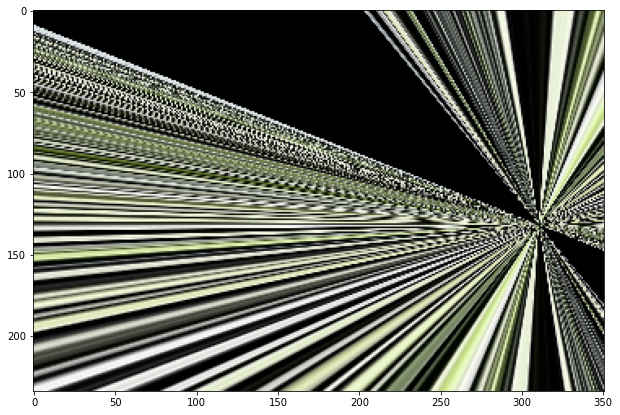

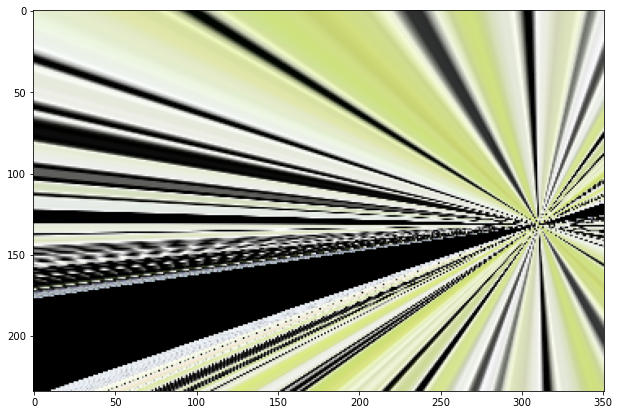

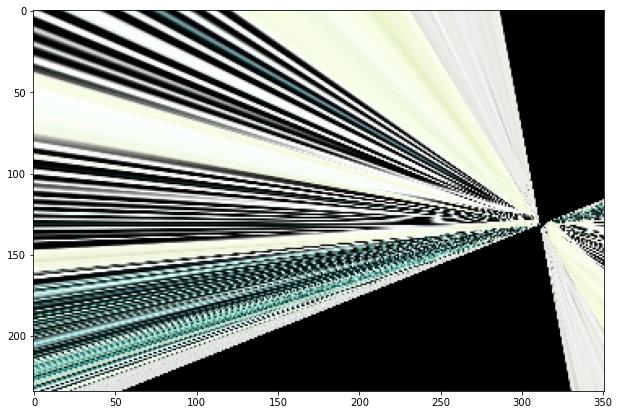

In [51]:
imgs = glob.glob("../capturadas/*.jpg")
ref = cv2.imread("../referencias/ref.jpg")

# plt.imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
# plt.show()

for n in imgs:
    
    img = cv2.imread(n)
    crop = cropImg(img)
    aligned, h = sift_align(crop, ref)
    
    #filt = inverte(img)
    
    #nome = extraiNome(img)
    #cpf = get_cpf_roi(img)
    #datanasc = get_datanasc_roi(img)
    #numreg = get_nreg_roi(img)
    
    plt.imshow(cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB))
    plt.show()

#     keys = data_keys(nome)
#     boxes = drawboxes(nome, keys)
    